In [1]:
a = {'b' : 2, 'a' : 3}

a.items()

dict_items([('b', 2), ('a', 3)])

# Imports

In [1]:
from importlib import reload
import json
import logging
import time
from argparse import ArgumentParser
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import datasets
from model import CNN

import utils
reload(utils)

<module 'utils' from '/Users/petr12375/Documents/mipt/m1p/2023-Project-120/code/utils.py'>

# Hyperparameters

In [2]:
layers = 1
batch_size = 64
log_frequency = 10
channels = 16
unrolled = False
visualization = False

# Getting dataset

In [3]:
dataset = "fashionmnist"

dataset_train, dataset_valid = datasets.get_dataset(dataset)        

# Search of the optimal architecture

In [4]:
save_folder = 'checkpoints/0'
epochs = 10
lambd = 0

if dataset == "fashionmnist":
    model = CNN(32, 1, channels, 10, layers)
if dataset == "cifar10":
    model = CNN(32, 3, channels, 10, layers)

criterion = nn.CrossEntropyLoss() # mycriterion()
optim = torch.optim.SGD(model.parameters(), 0.025, momentum=0.9, weight_decay=3.0E-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, epochs, eta_min=0.001)
trainer = utils.MyDartsTrainer( # MyDartsTrainer
    model=model,
    loss=criterion, # =mycriterion,
    metrics=lambda output, target: utils.accuracy(output, target, topk=(1,)),
    optimizer=optim,
    num_epochs=epochs,
    dataset=dataset_train,
    batch_size=batch_size,
    log_frequency=log_frequency,
    unrolled=unrolled,
    weight=1e3, # вес регуляризатора
    lambd=lambd, # количество общих ребер
    train_as_optimal=True,
    optimalPath='checkpoints/' + dataset + '/optimal/arc.json',
    tau=0.98,
    learning_rate=2.5E-3,
    arc_learning_rate=3.0E-1,
)
trainer.fit()
final_architecture = trainer.export()
print('Final architecture:', final_architecture)
if trainer.train_as_optimal:
    json.dump(trainer.export(), open(f'checkpoints/' + dataset + '/optimal/arc.json', 'w+'))
else:
    json.dump(trainer.export(), open(f'checkpoints/' + dataset + '/lambd={lambd}/arc.json', 'w+'))
# json.dump(trainer.export(), open(f"checkpoints/lambd={lambd}" + '/arc.json', 'w+'))


[2023-12-31 07:18:51] INFO (nni.retiarii.oneshot.pytorch.darts/MainThread) Epoch [1/10] Step [1/469]  acc1 0.046875 (0.046875)  loss 2.298134 (2.298134)


KeyboardInterrupt: 

# Architecture search for a range of $\lambda$

In [ ]:
save_folder = 'checkpoints/0'
epochs = 10
lambdas = [1, 2]
weight = 2

for lambd in lambdas:
    print(f"weight = {weight}, lambd = {lambd}")
    if dataset == "fashionmnist":
        model = CNN(32, 1, channels, 10, layers)
    if dataset == "cifar10":
        model = CNN(32, 3, channels, 10, layers)

    criterion = nn.CrossEntropyLoss() # mycriterion()
    optim = torch.optim.SGD(model.parameters(), 0.025, momentum=0.9, weight_decay=3.0E-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, epochs, eta_min=0.001)
    trainer = utils.MyDartsTrainer( # MyDartsTrainer
        model=model,
        loss=criterion, # =mycriterion,
        metrics=lambda output, target: utils.accuracy(output, target, topk=(1,)),
        optimizer=optim,
        num_epochs=epochs,
        dataset=dataset_train,
        batch_size=batch_size,
        log_frequency=log_frequency,
        unrolled=unrolled,
        weight=weight, # вес регуляризатора
        lambd=lambd, # количество общих ребер
        train_as_optimal=False,
        optimalPath='checkpoints/' + dataset + '/optimal/arc.json',
        tau=0.98,
        learning_rate=2.5E-3,
        arc_learning_rate=3.0E-1,
    )
    trainer.fit()
    final_architecture = trainer.export()
    print('Final architecture:', final_architecture)
    json.dump(trainer.export(), open(f'checkpoints/' + dataset + '/lambd={lambd}/arc.json', 'w+'))
    # json.dump(trainer.export(), open(f"checkpoints/lambd={lambd}" + '/arc.json', 'w+'))


weight = 1000.0, lambd = 3.5
[2023-10-22 11:42:00] Epoch [1/10] Step [1/469]  acc1 0.109375 (0.109375)  loss 5281.082520 (5281.082520)
[2023-10-22 11:42:01] Epoch [1/10] Step [11/469]  acc1 0.093750 (0.083807)  loss 186.878647 (1929.453348)
[2023-10-22 11:42:02] Epoch [1/10] Step [21/469]  acc1 0.062500 (0.074405)  loss 166.476303 (1124.850833)
[2023-10-22 11:42:04] Epoch [1/10] Step [31/469]  acc1 0.109375 (0.079133)  loss 3124.931885 (1001.904640)
[2023-10-22 11:42:05] Epoch [1/10] Step [41/469]  acc1 0.062500 (0.082317)  loss 176.438950 (888.207335)
[2023-10-22 11:42:07] Epoch [1/10] Step [51/469]  acc1 0.109375 (0.090074)  loss 171.233185 (750.694304)
[2023-10-22 11:42:08] Epoch [1/10] Step [61/469]  acc1 0.125000 (0.093494)  loss 93.085716 (651.725369)
[2023-10-22 11:42:09] Epoch [1/10] Step [71/469]  acc1 0.140625 (0.104754)  loss 176.104324 (580.948936)
[2023-10-22 11:42:11] Epoch [1/10] Step [81/469]  acc1 0.218750 (0.114198)  loss 181.038223 (522.578136)
[2023-10-22 11:42:12] 

## Common edges

In [ ]:
arcs = []

with open(f'checkpoints/fashionMNIST/optimal/arc.json') as f:
    arc = json.load(f) # оптимальная архитектура в виде словаря
    arcs.append(arc)

lambds = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
for lamb in lambds:
    with open(f'checkpoints/fashionMNIST/lambd={lamb}/arc.json') as f:
        arc = json.load(f)
        arcs.append(arc)

all_intersections = []
for arc in arcs:
    intersections = []
    for other_arc in arcs:
        same = 0
        for n in range(2, 6):
            common_parents = set(arc[f"reduce_n{n}_switch"]) & set(other_arc[f"reduce_n{n}_switch"])
            for p in common_parents:
                key = f"reduce_n{n}_p{p}"
                if arc[key] == other_arc[key]:
                    same += 1
        intersections.append(same)
    all_intersections.append(intersections)
intersections_with_opt = all_intersections[0]
print(intersections_with_opt)


[8, 1, 2, 2, 3, 5, 6, 4, 8]


Text(0.5, 0, 'lambda')

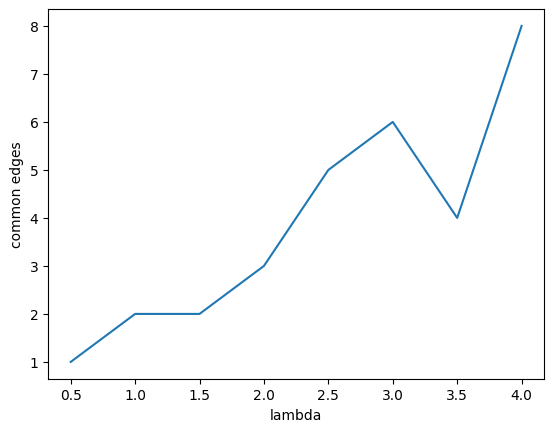

In [ ]:
y = intersections_with_opt[1:]
plt.plot(lambds, y)
plt.ylabel('common edges')
plt.xlabel('lambda')

## Retrain

In [ ]:
layers = 2
batch_size = 96
log_frequency = 20
channels = 16
unrolled = False
visualization = False

In [ ]:
from retrain import train, validate, fixed_arch
# reload(train)

config = {
'layers' : layers,
'batch_size' : batch_size,
'log_frequency' : log_frequency,
'epochs' : 10,
'aux_weight' : 0.4,
'drop_path_prob' : 0.1,
'workers' : 4,
'grad_clip' : 5.,
'save_folder' : "./checkpoints/fashionMNIST/",
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_train, dataset_valid = datasets.get_dataset("fashionmnist", cutout_length=16)

best_top1s = []
for lambd in [1, 2]:
    if lambd == 0:
        folder = config['save_folder'] + "optimal/"
    else:
        folder = config['save_folder'] + f"lambd={lambd}/"
    print(folder)
    with fixed_arch(folder + 'arc.json'):
    # with fixed_arch(args.save_folder + "/arc.json"):
        model = CNN(32, 1, 36, 10, config['layers'], auxiliary=True)

    criterion = nn.CrossEntropyLoss()

    model.to(device)
    criterion.to(device)

    optimizer = torch.optim.SGD(model.parameters(), 0.025, momentum=0.9, weight_decay=3.0E-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['epochs'], eta_min=1E-6)

    train_loader = torch.utils.data.DataLoader(dataset_train,
                                            batch_size=config['batch_size'],
                                            shuffle=True,
                                            num_workers=config['workers'],
                                            pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(dataset_valid,
                                            batch_size=config['batch_size'],
                                            shuffle=False,
                                            num_workers=config['workers'],
                                            pin_memory=True)

    best_top1 = 0.
    for epoch in range(config['epochs']):
        drop_prob = config['drop_path_prob'] * epoch / config['epochs']
        model.drop_path_prob(drop_prob)

        # training
        train(config, train_loader, model, optimizer, criterion, epoch)

        # validation
        cur_step = (epoch + 1) * len(train_loader)
        top1 = validate(config, valid_loader, model, criterion, epoch, cur_step)
        best_top1 = max(best_top1, top1)

        lr_scheduler.step()

    torch.save(model.state_dict(), folder + "mod.json")
    # torch.save(model.state_dict(), args.save_folder + "/mod.json")
    print("Final best Prec@1 = {:.4%}".format(best_top1))
    best_top1s.append(best_top1)
    print(best_top1s)

./checkpoints/fashionMNIST/lambd=0.5/
[2023-10-23 13:58:48] Fixed architecture: {'reduce_n2_p0': 'avgpool', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'avgpool', 'reduce_n3_p2': 'maxpool', 'reduce_n4_p0': 'maxpool', 'reduce_n4_p1': 'sepconv5x5', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'sepconv5x5', 'reduce_n5_p1': 'sepconv3x3', 'reduce_n5_p2': 'skipconnect', 'reduce_n5_p3': 'skipconnect', 'reduce_n5_p4': 'sepconv5x5', 'reduce_n2_switch': [0, 1], 'reduce_n3_switch': [2, 0], 'reduce_n4_switch': [0, 1], 'reduce_n5_switch': [4, 0]}
[2023-10-23 13:58:49] Epoch 0 LR 0.025000
[2023-10-23 13:58:51] Train: [  1/10] Step 000/624 Loss 3.353 Prec@(1,5) (6.2%, 46.9%)
[2023-10-23 13:58:52] Train: [  1/10] Step 020/624 Loss 2.719 Prec@(1,5) (25.7%, 70.8%)
[2023-10-23 13:58:53] Train: [  1/10] Step 040/624 Loss 2.274 Prec@(1,5) (36.8%, 82.2%)
[2023-10-23 13:58:53] Train: [  1/10] Step 060/624 Loss 2.023 Prec@(1,5) (43.9%, 87.1%)
[202

## Validation

In [ ]:
import numpy as np
from glob import glob
from nni.retiarii.oneshot.pytorch.utils import AverageMeter
from torch.utils.tensorboard import SummaryWriter

logger = logging.getLogger('nni')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

config = {
'layers' : 2,
'batch_size' : 96,
'log_frequency' : 30,
'epochs' : 10,
'aux_weight' : 0.4,
'drop_path_prob' : 0.1,
'workers' : 4,
'grad_clip' : 5.,
'save_folder' : "./checkpoints/fashionMNIST/",
}

dataset_train, dataset_valid = datasets.get_dataset("fashionmnist", cutout_length=16)

res_dict_accur = {}
models = []

# chosen_lambdas = np.random.choice(8, size=3, replace=False) # выбранные lambda
chosen_lambdas = (1)

print(chosen_lambdas)

with fixed_arch(config['save_folder'] + "optimal/arc.json"):
    model = CNN(32, 1, 36, 10, config['layers'], auxiliary=True)
    model.to(device)
    model.load_state_dict(torch.load(config['save_folder'] + "optimal/mod.json"))
    model.eval()
    
    models.append(model)

for dir in glob(config['save_folder'] + "*"):
    if dir.split('\\')[-1] != 'optimal' and float(dir.split('\\')[-1].split('=')[-1]) in chosen_lambdas:
    # if dir == "./checkpoints\\0":
        print(dir)
        with fixed_arch(dir + "/arc.json"):
            model = CNN(32, 1, 36, 10, config['layers'], auxiliary=True)
        model.to(device)
        model.load_state_dict(torch.load(dir + "/mod.json"))
        model.eval()
        
        models.append(model)

print(f"Models in ensemble: {len(models)}")

valid_loader = torch.utils.data.DataLoader(dataset_valid,
                                            batch_size=config['batch_size'],
                                            shuffle=False,
                                            num_workers=config['workers'],
                                            pin_memory=True)
criterion = nn.CrossEntropyLoss()

top1 = AverageMeter("top1")
top5 = AverageMeter("top5")
losses = AverageMeter("losses")

# validation
softmax = nn.Softmax(dim=1)
for step, (X, y) in enumerate(valid_loader):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        bs = X.size(0)

        probabilities = softmax(models[0](X))
        for i in range(1, len(models)):
            probabilities += softmax(models[i](X))
        probabilities = probabilities / len(models)
        loss = criterion(probabilities, y)

        accuracy = utils.accuracy(probabilities, y, topk=(1, 5))
        losses.update(loss.item(), bs)
        top1.update(accuracy["acc1"], bs)
        top5.update(accuracy["acc5"], bs)

        if step % config['log_frequency'] == 0 or step == len(valid_loader) - 1:
            logger.info(
                "Valid: Step {:03d}/{:03d} Loss {losses.avg:.3f} "
                "Prec@(1,5) ({top1.avg:.1%}, {top5.avg:.1%})".format(
                    step, len(valid_loader) - 1, losses=losses,
                    top1=top1, top5=top5))

logger.info("Final best Prec@1 = {:.4%}".format(top1.avg))

res_dict_accur[chosen_lambdas] = top1.avg
print(res_dict_accur)